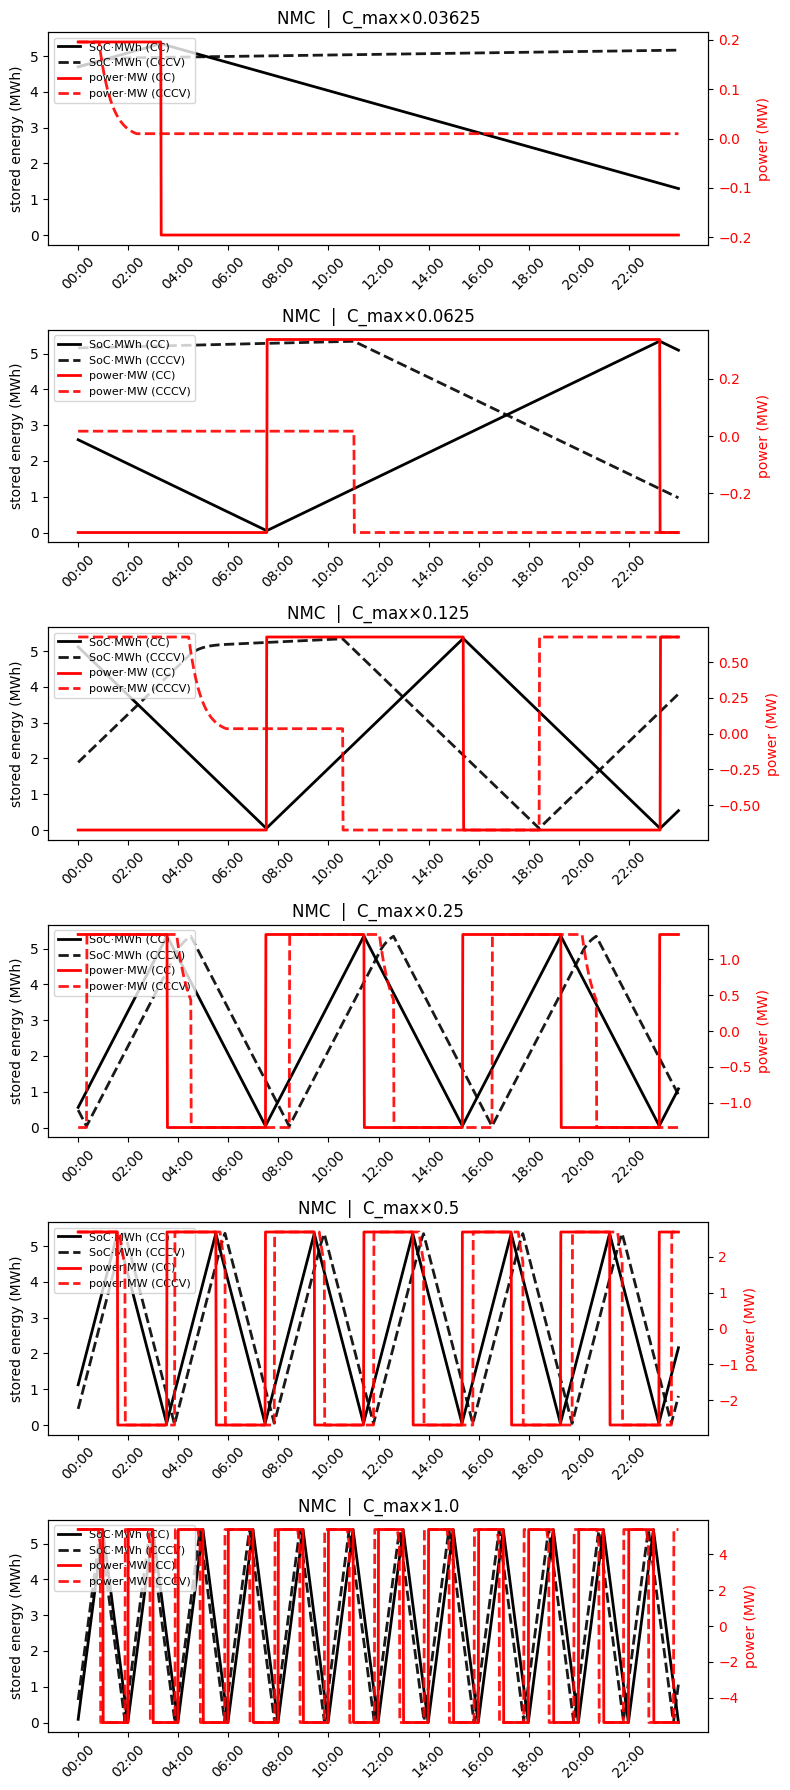

C:\Users\msz\AppData\Local\Temp\ipykernel_70088\4079094290.py:317: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\msz\anaconda3\envs\battery\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


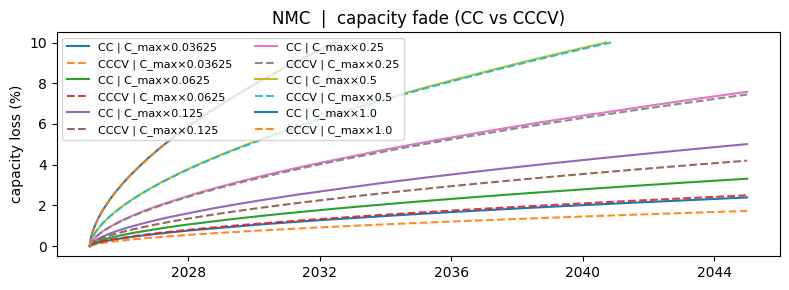

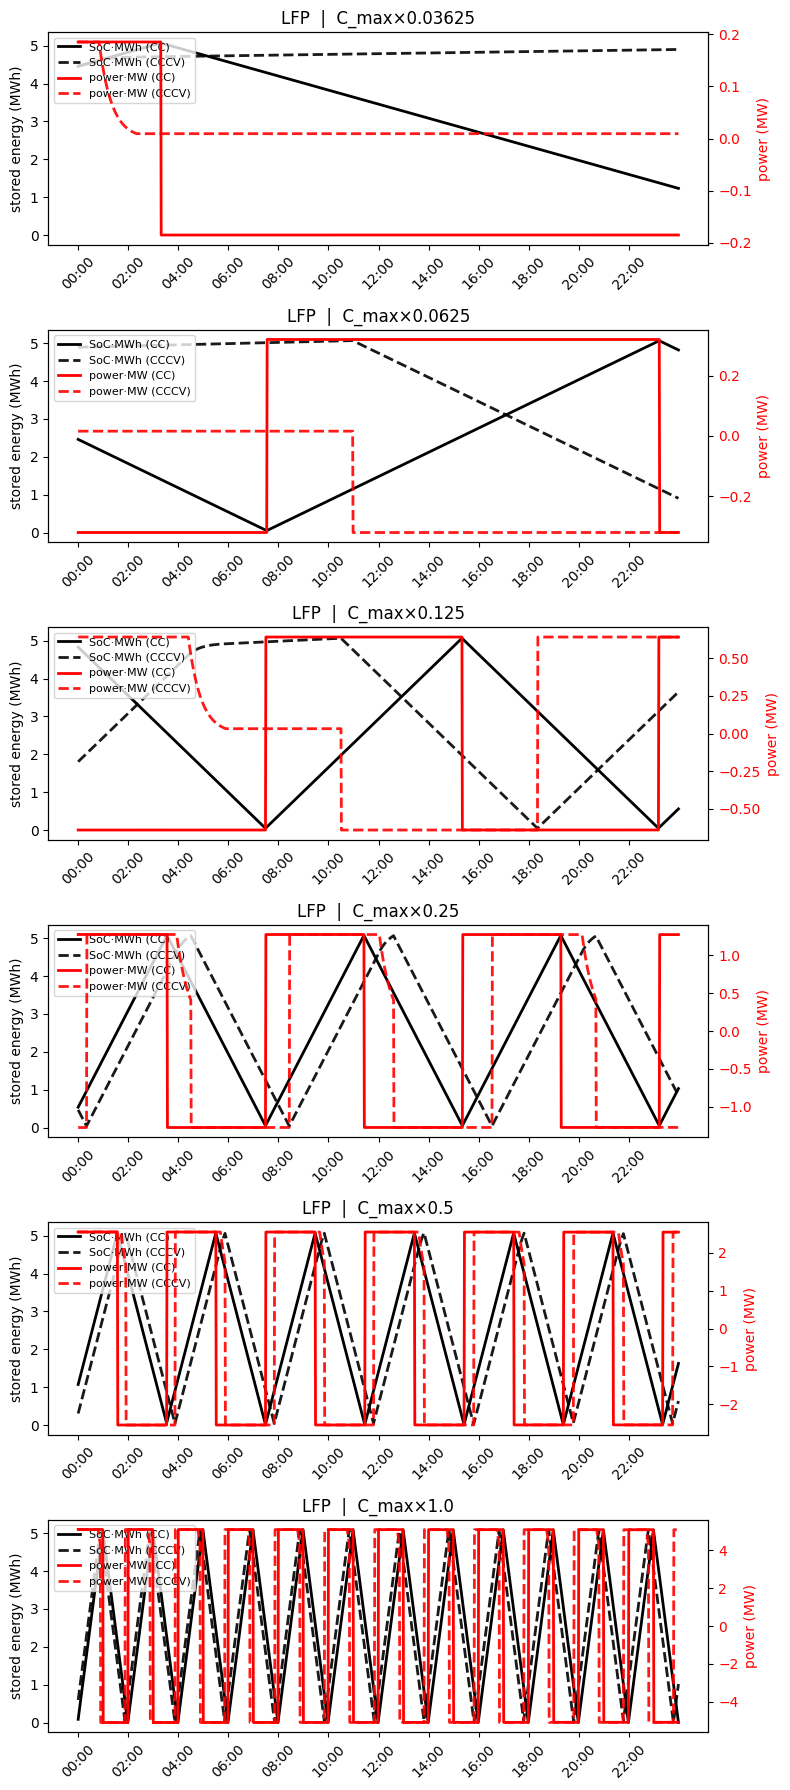

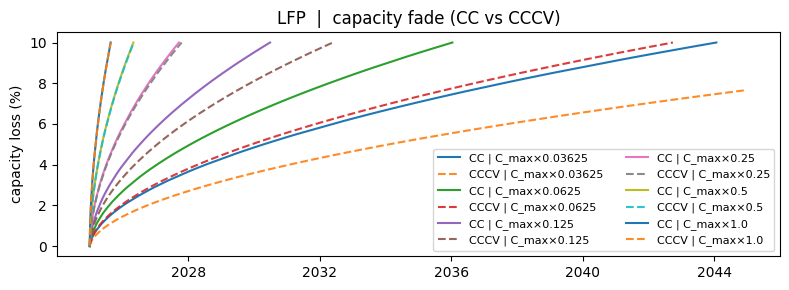


===== SUMMARY (CC vs CCCV) =====


,Protocol,Chem,C_rate_mult,Lifetime_yr,Cycles,Ah_Throughput
0,CC,NMC,0.03625,20.016436,3240,18786
1,CCCV,NMC,0.03625,20.016436,1886,10981
2,CC,NMC,0.06250,20.016436,5585,32198
3,CCCV,NMC,0.06250,20.016436,3476,20129
4,CC,NMC,0.12500,20.016436,11158,63690
5,CCCV,NMC,0.12500,20.016436,8288,47517
6,CC,NMC,0.25000,20.016436,22270,125235
7,CCCV,NMC,0.25000,20.016436,21648,121739
8,CC,NMC,0.50000,15.721718,34832,193543
9,CCCV,NMC,0.50000,15.874979,34985,193655


In [19]:
import os
import sys
import time
import calendar
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

### --- CHANGE 1 : 多电芯参数库（保持不变） -------------------------------
cell_library = {
    'NMC': dict(
        H=24*60, C_max=1.0, tilde_Q_1=3.0, tilde_V=3.6, N=0.5,
        cons_z=0.60, cons_alpha=29.0, cons_beta=74.0, cons_delta=1/60,
        cons_eta=155.0, cons_E_a=35000, cons_R_g=8.314, cons_T=273.15+25,
        cons_omega=np.exp(-35000/(8.314*(273.15+25)))
    ),
    'LFP': dict(
        H=24*60, C_max=1.0, tilde_Q_1=3.2, tilde_V=3.2, N=0.5,
        cons_z=0.55, cons_alpha=25.0, cons_beta=70.0, cons_delta=1/60,
        cons_eta=120.0, cons_E_a=30000, cons_R_g=8.314, cons_T=273.15+25,
        cons_omega=np.exp(-30000/(8.314*(273.15+25)))
    )
}
cell_constants = cell_library['NMC']
### --- CHANGE 1 END ---------------------------------------------

### --- CHANGE 2 : 工具函数 ---------------------------------------
def choose_cell(chemistry: str):
    import copy
    if chemistry not in cell_library:
        raise ValueError(f'未知电芯类型: {chemistry}')
    return copy.deepcopy(cell_library[chemistry])
### --- CHANGE 2 END ---------------------------------------------

# ========== 老化模型（保持不变） ==================================
def aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False):
    mu_t = cell_constants['cons_beta'] * cell_constants['cons_omega'] * cell_constants['cons_z'] * np.power(ah_t, cell_constants['cons_z'] - 1)
    nu_t = 0 if tilde_Q_t == 0 else cell_constants['cons_alpha'] / (cell_constants['cons_beta'] * tilde_Q_t)
    lambda_t = 0 if tilde_Q_t == 0 else cell_constants['cons_eta'] / (cell_constants['cons_R_g'] * cell_constants['cons_T'] * tilde_Q_t)
    if approx == False:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * tilde_q_t)) * np.exp(lambda_t * abs(tilde_b_t))
    else:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * (tilde_Q_t/2)))
    Sigma_rho_t = Sigma_rho_t + rho_t
    l_t = Sigma_rho_t * cell_constants['cons_delta']
    tilde_Q_t = cell_constants['tilde_Q_1'] * (1 - l_t)
    return l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t

# ========== 原 CC（bang-bang）模拟器（保持不变） ==================
def bang_bang_simulator(cell_constants: dict, approx=False):
    E = int(20 * 365 * cell_constants['H'] + 6 * cell_constants['H'])
    tilde_b = np.zeros((E,))
    tilde_q = np.zeros((E,))
    tilde_Q = np.zeros((E,))
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))

    cycle_state = 'charge'
    tilde_b_t = 0.0
    tilde_q_t = 0.0
    tilde_q_t_1 = 0.0
    tilde_Q_t = cell_constants['tilde_Q_1']
    Sigma_rho_t = 0.0
    ah_t = 2.5

    for e in range(E):
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break

        tilde_b_t = -cell_constants['C_max'] * tilde_Q_t if cycle_state == 'charge' \
                    else  cell_constants['C_max'] * tilde_Q_t

        tilde_q_t_1 = tilde_q_t
        tilde_q_t = np.clip(tilde_q_t_1 - tilde_b_t * cell_constants['cons_delta'], 0, tilde_Q_t)
        tilde_b_t = (tilde_q_t - tilde_q_t_1) / cell_constants['cons_delta']

        ah_t = ah_t + (abs(tilde_b_t) * cell_constants['cons_delta'])
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(
            tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx
        )
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5 * tilde_Q_t))

        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        l[e] = l_t
        ah[e] = ah_t
        Sigma_rho[e] = Sigma_rho_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t

        if cycle_state == 'charge' and tilde_q_t >= 0.99 * tilde_Q_t:
            cycle_state = 'discharge'
        elif cycle_state == 'discharge' and tilde_q_t <= 0.01 * tilde_Q_t:
            cycle_state = 'charge'

    E_sim = e
    tilde_b = tilde_b[:E_sim]
    tilde_q = tilde_q[:E_sim]
    tilde_Q = tilde_Q[:E_sim]
    l = l[:E_sim]
    ah = ah[:E_sim]
    mu_one_plus_nu_q = mu_one_plus_nu_q[:E_sim]
    Sigma_rho = Sigma_rho[:E_sim]

    cell_variables = {
        'tilde_b': tilde_b, 'tilde_q': tilde_q, 'tilde_Q': tilde_Q,
        'l': l, 'ah': ah, 'mu_one_plus_nu_q': mu_one_plus_nu_q, 'Sigma_rho': Sigma_rho
    }
    lifetime_in_years = E_sim / (365 * cell_constants['H'])
    num_cycles = np.sum(np.diff(np.sign(tilde_b)) != 0) // 2
    ah_at_the_end = ah[-1]
    return cell_variables, E_sim, lifetime_in_years, num_cycles, ah_at_the_end

# ========== 新增：CCCV 模拟器 ====================================
def cccv_simulator(cell_constants: dict, approx=False,
                   s_cv_start=0.90,     # 进入 CV 的 SoC 阈值（相对当期容量 Q_t）
                   I_min_frac=0.05,     # CV 尾充的最小电流 = I0 * I_min_frac
                   tau_cv_hours=0.5):   # CV 电流指数衰减时间常数（小时）
    """
    充电策略：CC -> CV 尾充；放电维持 CC。
    其他更新（老化、容量衰减）与 CC 版本一致。
    """
    E = int(20 * 365 * cell_constants['H'] + 6 * cell_constants['H'])
    tilde_b = np.zeros((E,))
    tilde_q = np.zeros((E,))
    tilde_Q = np.zeros((E,))
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))

    # 状态
    phase = 'charge_cc'     # 'charge_cc' | 'charge_cv' | 'discharge_cc'
    t_cv = 0.0              # 进入 CV 后累计时间（小时）
    I0_cv = 0.0             # 进入 CV 时刻的恒流电流幅值（A）
    delta_h = cell_constants['cons_delta']

    tilde_b_t = 0.0
    tilde_q_t = 0.0
    tilde_q_t_1 = 0.0
    tilde_Q_t = cell_constants['tilde_Q_1']
    Sigma_rho_t = 0.0
    ah_t = 2.5

    for e in range(E):
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break

        # ---- 计算当步电流（A，放电为正，充电为负）----
        if phase == 'charge_cc':
            # 恒流充电
            tilde_b_t = -cell_constants['C_max'] * tilde_Q_t
            # 达到 CV 起始 SoC 切换
            if tilde_q_t >= s_cv_start * tilde_Q_t:
                phase = 'charge_cv'
                t_cv = 0.0
                I0_cv = cell_constants['C_max'] * tilde_Q_t  # 进入 CV 时刻的恒流幅值
        elif phase == 'charge_cv':
            # 指数衰减：I(t) = max(I_min, I0 * exp(-t/tau))
            I_min = I0_cv * I_min_frac
            I_now = max(I_min, I0_cv * np.exp(-t_cv / tau_cv_hours))
            tilde_b_t = -I_now
        else:  # 'discharge_cc'
            tilde_b_t =  cell_constants['C_max'] * tilde_Q_t

        # ---- SoC 更新（离散积分，并裁剪到[0, Q_t]）----
        tilde_q_t_1 = tilde_q_t
        tilde_q_t = np.clip(tilde_q_t_1 - tilde_b_t * delta_h, 0, tilde_Q_t)
        # 用“实际到边界”的位移，反推真实电流（避免越界导致的能量误差）
        tilde_b_t = (tilde_q_t - tilde_q_t_1) / delta_h

        # ---- 状态机切换 ----
        if phase in ('charge_cc', 'charge_cv'):
            # 充到 99% 视为结束，转放电
            if tilde_q_t >= 0.99 * tilde_Q_t:
                phase = 'discharge_cc'
                t_cv = 0.0
            elif phase == 'charge_cv':
                # CV 仍在进行，时间推进
                t_cv += delta_h
        elif phase == 'discharge_cc':
            if tilde_q_t <= 0.01 * tilde_Q_t:
                phase = 'charge_cc'
                t_cv = 0.0

        # ---- 老化与记录 ----
        ah_t = ah_t + (abs(tilde_b_t) * delta_h)
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(
            tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx
        )
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5 * tilde_Q_t))

        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        l[e] = l_t
        ah[e] = ah_t
        Sigma_rho[e] = Sigma_rho_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t

    E_sim = e
    tilde_b = tilde_b[:E_sim]
    tilde_q = tilde_q[:E_sim]
    tilde_Q = tilde_Q[:E_sim]
    l = l[:E_sim]
    ah = ah[:E_sim]
    mu_one_plus_nu_q = mu_one_plus_nu_q[:E_sim]
    Sigma_rho = Sigma_rho[:E_sim]

    cell_variables = {
        'tilde_b': tilde_b, 'tilde_q': tilde_q, 'tilde_Q': tilde_Q,
        'l': l, 'ah': ah, 'mu_one_plus_nu_q': mu_one_plus_nu_q, 'Sigma_rho': Sigma_rho
    }
    lifetime_in_years = E_sim / (365 * cell_constants['H'])
    num_cycles = np.sum(np.diff(np.sign(tilde_b)) != 0) // 2
    ah_at_the_end = ah[-1]
    return cell_variables, E_sim, lifetime_in_years, num_cycles, ah_at_the_end

# === MAIN EXPERIMENT LOOP（加入 CC vs CCCV） ===============================
chem_list = list(cell_library.keys())     # e.g. ['NMC', 'LFP']
rate_mults = [0.03625, 0.0625, 0.125, 0.25, 0.5, 1.0]
protocols = ['CC', 'CCCV']               # 两个协议
proto_style = {'CC': dict(ls='-',  lw=2.0, alpha=1.0),
               'CCCV': dict(ls='--', lw=2.0, alpha=0.9)}

summary_rows = []
for chem in chem_list:
    const_base = choose_cell(chem)
    H = const_base['H']

    # 存放 “(protocol, mult) -> (q,b) / l”
    daily_profiles = {}
    loss_profiles  = {}

    for mult in rate_mults:
        # 两个协议分别跑
        for proto in protocols:
            const = choose_cell(chem)
            const['C_max'] = const['C_max'] * mult

            if proto == 'CC':
                cell_vars, E_sim, life, cycles, ah_end = bang_bang_simulator(const, approx=False)
            else:  # 'CCCV'
                cell_vars, E_sim, life, cycles, ah_end = cccv_simulator(const, approx=False)

            # 只留一天做“充放电曲线”展示（按你原来的逻辑，取 [H:2H]）
            q = cell_vars['tilde_q'] * const['N'] * const['tilde_V']
            b = cell_vars['tilde_b'] * const['N'] * const['tilde_V']
            daily_profiles[(proto, mult)] = (q, b)

            # “容量衰减曲线” 全程
            loss_profiles[(proto, mult)] = cell_vars['l']

            summary_rows.append(
                dict(Protocol=proto, Chem=chem, C_rate_mult=mult,
                     Lifetime_yr=life, Cycles=cycles, Ah_Throughput=int(ah_end))
            )

    # -------------------------- 画图（每个 chem 单独成图） -------------------------
    # 1) 一天内充放电曲线（同倍率下 CC 与 CCCV 叠加）
    times_day = pd.date_range('2000-01-01 00:00', periods=2*H, freq='1min')
    fig, axes = plt.subplots(len(rate_mults), 1, figsize=(8, 3*len(rate_mults)), sharey='col')
    if len(rate_mults) == 1:
        axes = [axes]

    for idx, mult in enumerate(rate_mults):
        ax = axes[idx]
        # SoC 轴（黑色），功率轴（红色）
        for proto in protocols:
            q, b = daily_profiles[(proto, mult)]
            sty = proto_style[proto]
            ax.plot(times_day[H:2*H], q[H:2*H], color='k', lw=sty['lw'],
                    ls=sty['ls'], alpha=sty['alpha'], label=f'SoC·MWh ({proto})')
        ax.set_ylabel('stored energy (MWh)')
        ax.set_xticks(pd.date_range(times_day.min(), times_day.max(), freq='2h'))
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'{chem}  |  C_max×{mult}')

        ax_t = ax.twinx()
        for proto in protocols:
            q, b = daily_profiles[(proto, mult)]
            sty = proto_style[proto]
            ax_t.plot(times_day[H:2*H], b[H:2*H], color='red', lw=sty['lw'],
                      ls=sty['ls'], alpha=sty['alpha'], label=f'power·MW ({proto})')
        ax_t.set_ylabel('power (MW)', color='red')
        ax_t.tick_params(axis='y', labelcolor='red')

        # 合并图例（两个 y 轴）
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax_t.get_legend_handles_labels()
        ax.legend(lines1+lines2, labels1+labels2, loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

    # 2) 全寿命容量衰减（同倍率、不同协议叠加）
    fig, ax = plt.subplots(figsize=(8, 3))
    for mult in rate_mults:
        for proto in protocols:
            l = loss_profiles[(proto, mult)]
            t = pd.date_range('2025-01-01', periods=len(l), freq='1min')
            sty = proto_style[proto]
            ax.plot(t, l*100, lw=1.5, ls=sty['ls'], alpha=sty['alpha'],
                    label=f'{proto} | C_max×{mult}')
    ax.set_ylabel('capacity loss (%)')
    ax.set_title(f'{chem}  |  capacity fade (CC vs CCCV)')
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

# ====================== 打印总结表 ============================================
summary_df = pd.DataFrame(summary_rows)
print('\n===== SUMMARY (CC vs CCCV) =====')
try:
    from IPython.display import display
except:
    pass
display(summary_df)
